# Taller3: Sistema de recuperación texto‑imagen con CLIP sobre el dataset Caltech‑256

* María Sofía Uribe
* Javier Daza Olivella


Instalamos e importamos librerías necesarias

In [1]:
!pip -q install "open-clip-torch" "faiss-cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44

In [2]:
# librerías básicas
import os
import sys
import time
import glob
import json
import math
import shutil
import random
import tarfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt


# torch
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# open clip
import open_clip

# faiss 
import faiss



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Primero definimos algunas configuraciones, entre ellas escogemos qué fracción  vamos a seleccionar del dataset y escogemos excluir la categoría '257.clutter' para métricas más informativas.

El modelo a usar es ViT-B-32 aunque se puede seleccionar uno diferente (ViT-B-16, ViT-L-14, RN50), también seleccionamos los pesos del modelo pre entrenado, la combinación de modelo y pesos ofrece una relación favorable entre rendimiento y costo computacional. Usaremos un tamaño de lote de 64 y mostraremos el top 12 de resultados en las búsquedas



In [3]:

SAMPLE_FRACTION = 0.20
SAMPLE_SEED = 42
EXCLUDE_CLUTTER = True


CLIP_ARCH = "ViT-B-32"
CLIP_PRETRAINED = "laion2b_s34b_b79k"

TOPK = 12
BATCH_SIZE = 64
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Ahora descargamos el dataset de https://data.caltech.edu/records/nyy15-4j048  y lo subimos a nuestro entorno


In [4]:
DATA_DIR = Path("/kaggle/input/caltech-256")

In [5]:

DATA_ROOT  = DATA_DIR / "256_ObjectCategories"
classes = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
print(f"Clases: {len(classes)}")
classes[:10]


Clases: 257


['001.ak47',
 '002.american-flag',
 '003.backpack',
 '004.baseball-bat',
 '005.baseball-glove',
 '006.basketball-hoop',
 '007.bat',
 '008.bathtub',
 '009.bear',
 '010.beer-mug']

Verificamos los directorios y que hay 257 clases (hay una que es clutter)

Implementamos la lógica de carga y filtrado de las imágenes del dataset Caltech-256, iteramos sobre todas las clases disponibles, y cuando en este caso excluímos el clutter.Con esto construimos las rutas, etiquetas y nombres de clases

In [6]:
def is_clutter(cls_name: str) -> bool:
    """
    Determina si una clase del dataset corresponde a 'clutter' (ruido o fondo no informativo).

    Parámetros
    ----------
    cls_name : str
        Nombre de la clase a evaluar.

    Retorna
    -------
    bool
        True si la clase corresponde a 'clutter', False en caso contrario.
    """
    return cls_name.startswith("257.") or cls_name.lower().endswith("clutter")

In [7]:
all_image_paths, all_labels, all_class_names = [], [], []
for ci, cname in enumerate(classes):
    if is_clutter(cname):
        continue
    cdir = DATA_ROOT / cname
    for img_path in cdir.glob("*.jpg"):
        all_image_paths.append(img_path.as_posix())
        all_labels.append(ci)
        all_class_names.append(cname)

Ahora construímos un dataset a partir de los directorios de las imágenes y las etiquetas

In [8]:
df = pd.DataFrame({
    "path": all_image_paths,
    "label": all_labels,
    "class_name": all_class_names,
})
print("# de imágenes (sin clutter):", len(df))


# de imágenes (sin clutter): 29780


Tenemos 29780 imágenes en total

In [9]:
rng = np.random.default_rng(SAMPLE_SEED)
def per_class_sample(group):
    """
    realiza un muestreo aleatorio de un subconjunto de imágenes por clase.

    parámetros
    ----------
    group : pandas.DataFrame
        subconjunto de datos correspondiente a una clase específica (resultado de groupby).

    retorna
    -------
    pandas.DataFrame
        subconjunto aleatorio del grupo original con una fracción de muestras determinada por SAMPLE_FRACTION.
    """
    n = len(group)
    k = max(1, int(round(n * SAMPLE_FRACTION)))
    idx = rng.choice(n, size=k, replace=False)
    return group.iloc[idx]

df_sample = df.groupby("class_name", group_keys=False).apply(per_class_sample)
df_sample = df_sample.reset_index(drop=True)
print("# de imágenes seleccionadas:", len(df_sample))

# de imágenes seleccionadas: 5952


/tmp/ipykernel_19/3093730660.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("class_name", group_keys=False).apply(per_class_sample)


In [10]:
df_sample.head()

path  label class_name
0  /kaggle/input/caltech-256/256_ObjectCategories...      0   001.ak47
1  /kaggle/input/caltech-256/256_ObjectCategories...      0   001.ak47
2  /kaggle/input/caltech-256/256_ObjectCategories...      0   001.ak47
3  /kaggle/input/caltech-256/256_ObjectCategories...      0   001.ak47
4  /kaggle/input/caltech-256/256_ObjectCategories...      0   001.ak47

In [11]:
len(df_sample), len(set(df_sample['label'].values))

(5952, 256)

Tenemos una muestra de 5952 imágenes que abarcan las 256 clases (sin clutter)

Verificamos que todos los paths de imágenes estén correctos

In [12]:
df_sample['exists'] = df_sample['path'].apply(os.path.exists)
missing_sample = (~df_sample['exists']).sum()
print(f"imágenes faltantes en la muestra: {missing_sample} ")

imágenes faltantes en la muestra: 0 


Vemos si la muestra está balanceada o no 

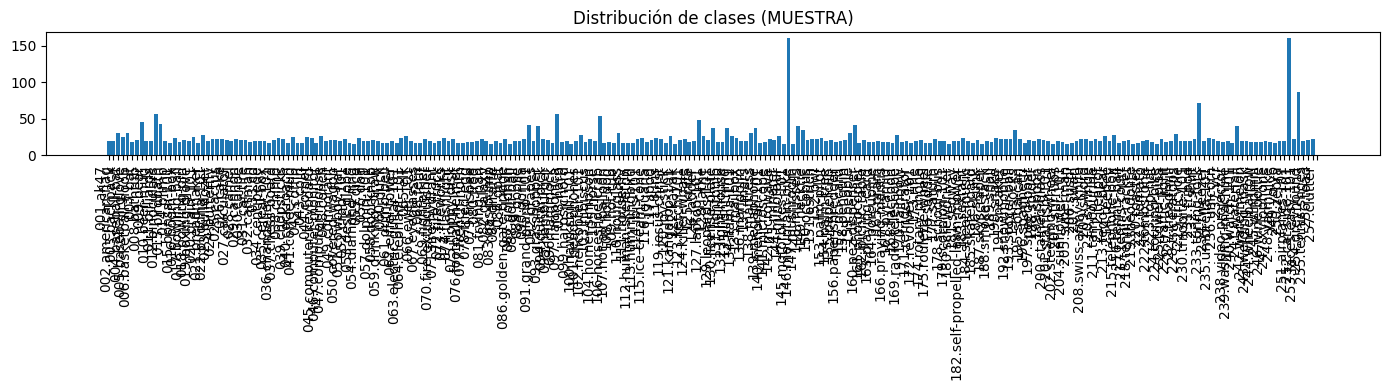

In [13]:
sample_counts = df_sample['class_name'].value_counts().sort_index()

heights = sample_counts.reindex(classes, fill_value=0)

plt.figure(figsize=(14,4))
plt.bar(range(len(heights)), heights.values)
plt.xticks(range(len(heights)), heights.index, rotation=90, ha='right')
plt.title('Distribución de clases (MUESTRA)')
plt.tight_layout()
plt.show()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ahora configuramos la parte fundamental del sistema de recuperación, primero cargamos el modelo CLIP y luego la preparación del conjunto de datos para generar embeddings. Usamos open_clip.create_model_and_transforms() para obtener el modelo, junto con las transformaciones de preprocesamiento que normalizan y escalan las imágenes según los requisitos del modelo seleccionado.

Definimos el dataset de torch y el dataloader se configura con parámetros que optimizan el flujo de datos.

Además, inicializamos el tokenizador mediante open_clip.get_tokenizer(), que será responsable de transformar consultas de texto en vectores numéricos interpretables por el modelo CLIP.

In [15]:

model, _, preprocess = open_clip.create_model_and_transforms(
    CLIP_ARCH, pretrained=CLIP_PRETRAINED, device=device
)

class CaltechSubset(Dataset):
    """
    Clase personalizada de Dataset para manejar el subconjunto de Caltech-256.

    Permite la carga de imágenes y sus etiquetas asociadas, aplicando el preprocesamiento
    necesario para que sean compatibles con el modelo CLIP.
    """
    def __init__(self, df):
        """ guarda el DataFrame con los metadatos"""
        self.df = df.reset_index(drop=True)
    def __len__(self):
        """ devuelve el número total de muestras en el subconjunto"""
        return len(self.df)
    def __getitem__(self, idx):
        """Recupera una fila específica del DataFrame."""
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        return preprocess(img), row["label"], row["class_name"], row["path"]

dataset = CaltechSubset(df_sample)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
len(dataset), next(iter(loader))[0].shape


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

(5952, torch.Size([64, 3, 224, 224]))

In [16]:

model, _, preprocess_info = open_clip.create_model_and_transforms(CLIP_ARCH, pretrained=CLIP_PRETRAINED, device=DEVICE)
tokenizer = open_clip.get_tokenizer(CLIP_ARCH)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

Ahora definimos el procedimiento de cómputo de embeddings, primero desactivamos el cálculo de gradientes, ya que el proceso es puramente inferencial y no requiere entrenamiento. Dentro del bucle procesamos cada lote de imágenes, cada imagen es codificada y posteriormente normalizamos los vectores resultantes dividiéndolos por su norma L2, garantizando que todos los embeddings tengan magnitud unitaria. 

Finalmente, verificamos la dimensión de salida de los embeddings, lo que confirma que el proceso de codificación se ejecutó correctamente y nos proporciona una referencia para el espacio latente del modelo.

In [17]:
@torch.no_grad()
def compute_image_embeddings(dataloader, model, device="cpu"):
    """
    Computa los embeddings de imagen utilizando el modelo CLIP.

    Este proceso convierte cada imagen del conjunto en un vector de características
    normalizado, que puede luego compararse con embeddings de texto para tareas
    de recuperación o búsqueda semántica.

    Parámetros
    ----------
    dataloader : torch.utils.data.DataLoader
        DataLoader que contiene las imágenes a procesar por lotes.
    model : torch.nn.Module
        Modelo CLIP preentrenado para codificar las imágenes.
    device : str, opcional
        Dispositivo en el que se realizará la inferencia ("cpu" o "cuda").
        Por defecto es "cpu".

    Retorna
    -------
    tuple
        - img_embs : np.ndarray
            Matriz con los embeddings de todas las imágenes (N x D).
        - labels : np.ndarray
            Vector de etiquetas de clase asociadas a cada imagen.
        - class_names : np.ndarray
            Nombres de clase correspondientes a cada imagen.
        - paths : np.ndarray
            Rutas de los archivos de imagen procesados.
    """
    img_embs = []
    paths = []
    labels = []
    class_names = []
    for imgs, lbls, cns, pths in tqdm(dataloader, desc="Embeddings de imágenes"):
        imgs = imgs.to(device, non_blocking=True)
        feats = model.encode_image(imgs)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        img_embs.append(feats.cpu().numpy())
        paths.extend(pths)
        labels.extend(lbls.numpy().tolist())
        class_names.extend(list(cns))
    img_embs = np.concatenate(img_embs, axis=0)
    return img_embs, np.array(labels), np.array(class_names), np.array(paths)

img_embs, y_labels, y_classnames, img_paths = compute_image_embeddings(loader, model, device=DEVICE)
print("Embeddings shape:", img_embs.shape)


Embeddings de imágenes: 100%|██████████| 93/93 [00:29<00:00,  3.20it/s]

Embeddings shape: (5952, 512)


En esta parte construimos el índice de búsqueda que permitirá realizar recuperación eficiente de imágenes a partir de consultas textuales o visuales. Primero, extraemos la dimensión de los embeddings (dim) para inicializar correctamente el índice FAISS. Escogemos faiss.IndexFlatIP, que implementa una búsqueda basada en producto interno (Inner Product). Dado que los embeddings fueron previamente normalizados a longitud unitaria, el producto interno entre dos vectores coincide con la similitud coseno, una métrica común en modelos de representación semántica. Luego, añadimos todos los embeddings al índice, lo que permite realizar consultas rápidas sin necesidad de recalcular distancias para cada par de vectores.

In [18]:
dim = img_embs.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(img_embs.astype(np.float32))
print("Índice FAISS listo con", index.ntotal, "vectores.")

Índice FAISS listo con 5952 vectores.


Ahora implementamos el flujo de consulta texto a imagen. Primero, en encode_text() transformamos una cadena de texto en un embedding CLIP mediante el tokenizador y el codificador de texto, luego normalizamos el vector resultante para operar con similitud coseno de forma correcta.


In [19]:

@torch.no_grad()
def encode_text(query: str):
    """
    codifica una consulta de texto en un embedding normalizado usando CLIP.

    Parámetros
    ----------
    query : str
        texto de la consulta que queremos mapear al espacio latente compartido
        de CLIP (texto-imagen).

    Retorna
    -------
    np.ndarray
        vector de características (embedding) L2-normalizado de dimensión D.
    """
    tokens = tokenizer([query])
    tokens = tokens.to(DEVICE)
    tfeat = model.encode_text(tokens)
    tfeat = tfeat / tfeat.norm(dim=-1, keepdim=True)
    return tfeat.squeeze(0).detach().cpu().numpy()




Definimos la lógica de recuperació, primero codificamos la consulta en un vector y leugo realizamos la búsqueda eficiente de los top-k elementos más similares usando producto interno (equivalente a coseno por la normalización previa). 



In [20]:

def search_text_to_image(query: str, topk=TOPK):
    """
    Realiza una búsqueda texto->imagen devolviendo los índices y puntajes de similitud.
    Parámetros
    ----------
    query : str
        Consulta textual a codificar y comparar contra los embeddings de imagen.
    topk : int, opcional
        Número de resultados a recuperar (por defecto TOPK).

    Retorna
    -------
    tuple
        - idxs : np.ndarray
            Índices de las imágenes más similares en el conjunto.
        - scores : np.ndarray
            Puntajes de similitud (producto interno ~ coseno con embeddings normalizados).
    """
    q = encode_text(query).astype(np.float32)
    D, I = index.search(q[None, :], topk)
    scores, idxs = D[0], I[0]
    return idxs, scores



Luego definimos cómo visualizar los resultados

In [21]:
def show_results(idxs, scores, ncols=4, figsize=(14,10), suptitle=None):
    """
    visualiza los resultados de la búsqueda mostrando miniaturas y sus puntajes.

    Parámetros
    ----------
    idxs : Iterable[int]
        índices de las imágenes a mostrar (en el arreglo global `img_paths`).
    scores : Iterable[float]
        puntajes de similitud correspondientes a cada índice.
    ncols : int, opcional
        número de columnas en la cuadrícula de visualización (por defecto 4).
    figsize : tuple, opcional
        tamaño de la figura de Matplotlib (ancho, alto) en pulgadas.
    suptitle : str, opcional
        título general para toda la figura.
    """
    n = len(idxs)
    ncols = min(ncols, n)
    nrows = int(math.ceil(n / ncols))
    plt.figure(figsize=figsize)
    for i, (idx, sc) in enumerate(zip(idxs, scores)):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(Image.open(img_paths[idx]).convert("RGB"))
        ax.set_title(f"{y_classnames[idx]}\nscore={sc:.3f}", fontsize=9)
        ax.axis("off")
    if suptitle:
        plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


## Ejemplo de uso 



Ahora incluimos ejemplos de uso

Al pasar una query para fotos de guantes obtenemos un top 12 de fotos de guantes tanto de boxeo como de beisból

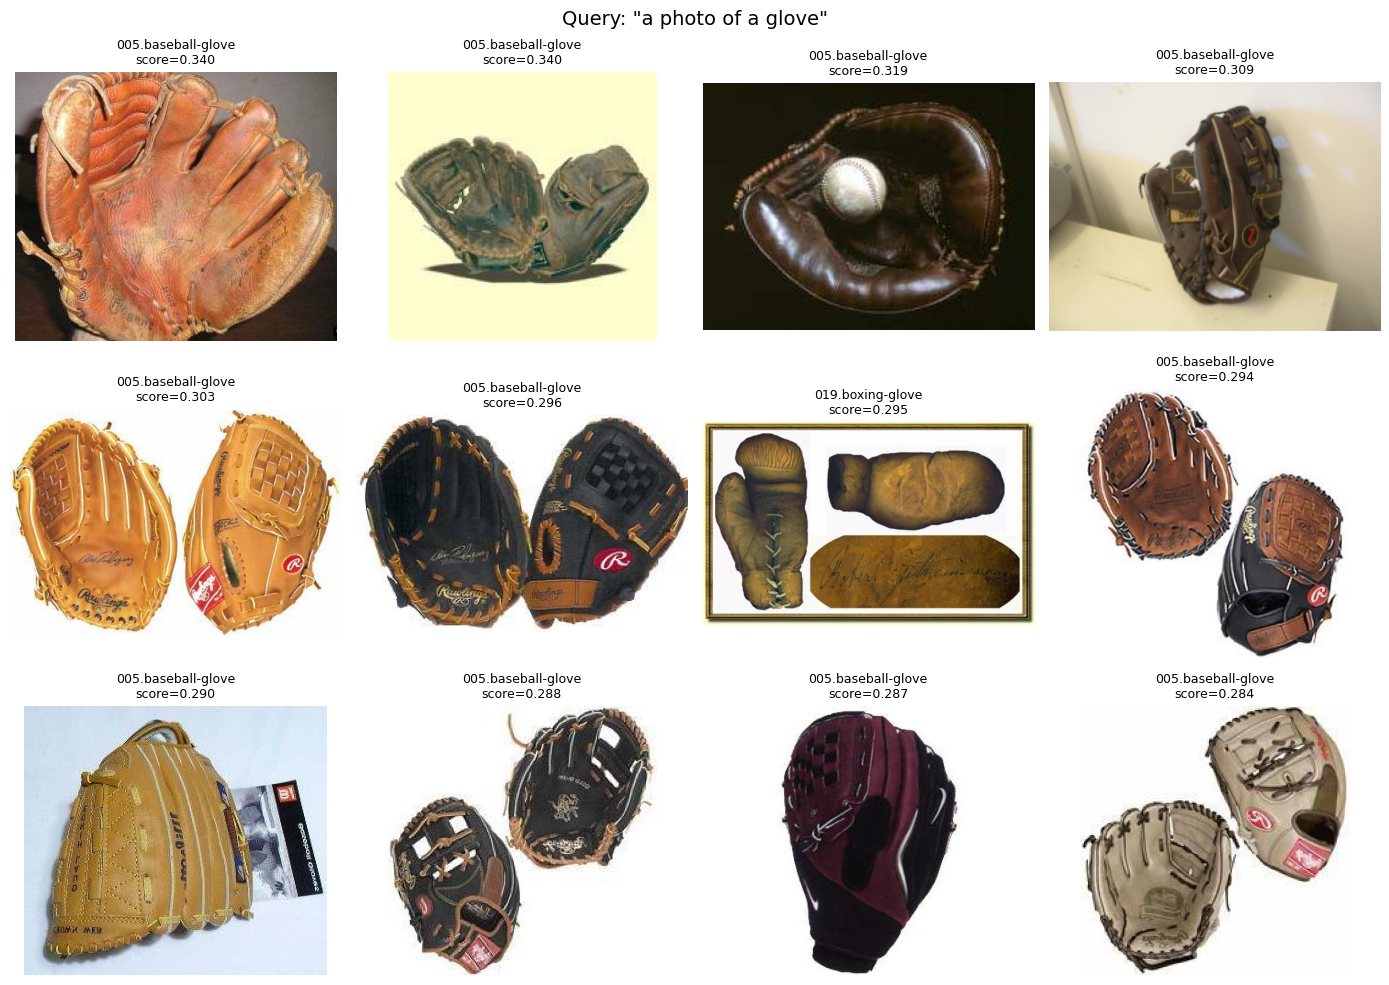

In [22]:
query = "a photo of a glove"
idxs, scores = search_text_to_image(query, topk=TOPK)
show_results(idxs, scores, suptitle=f'Query: "{query}"')


Al pasar una query para fotos de guitarras obtenemos un top 12 de fotos de guitarras eléctricas y mandolines (instrumento de cuerda de cuatro órdenes dobles de cuerdas muy parecido a una guitarra)

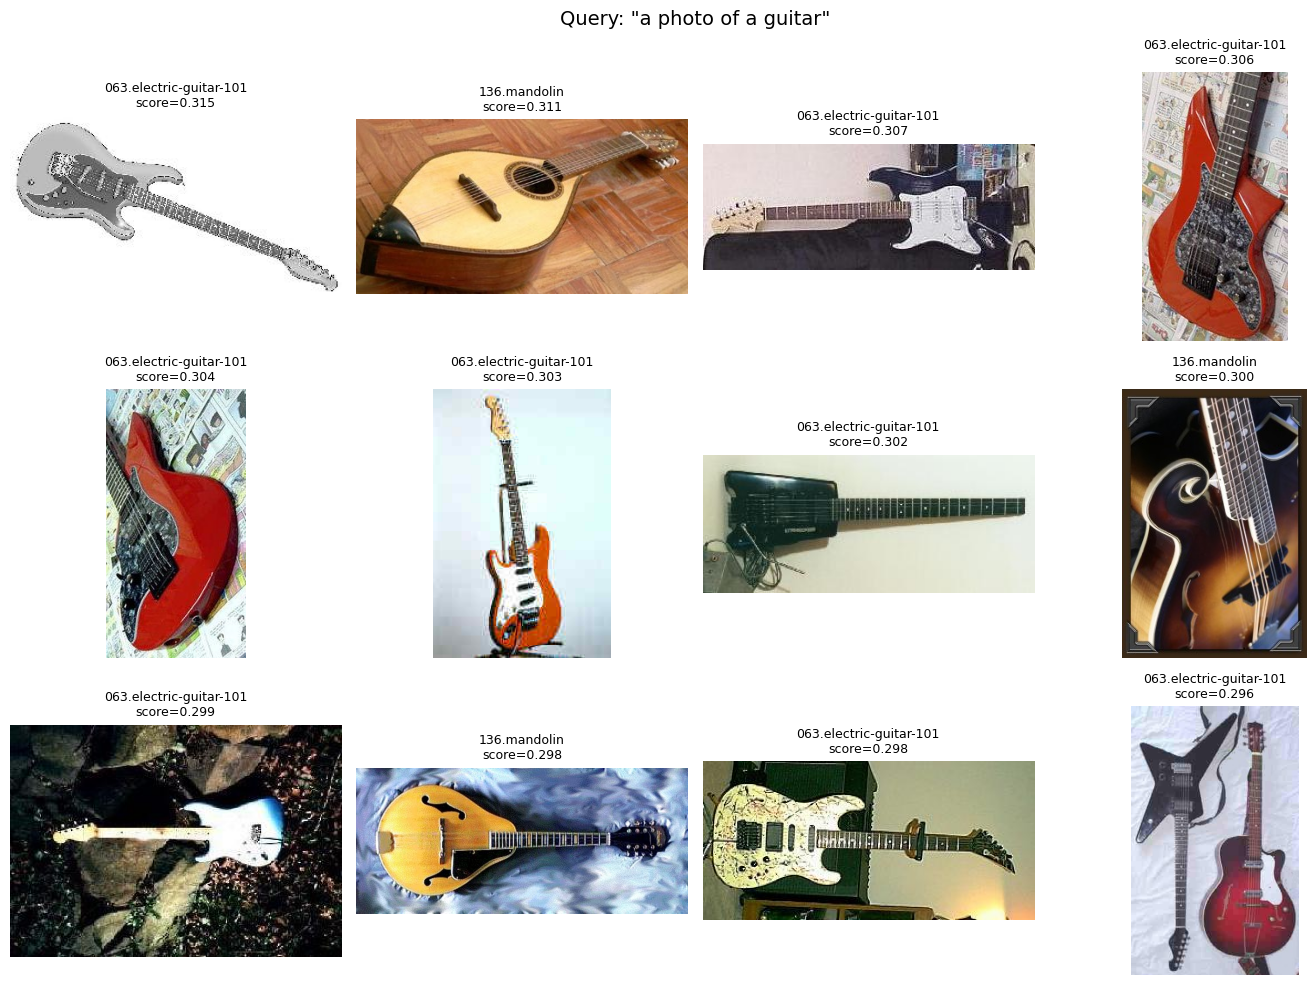

In [23]:
query = "a photo of a guitar"
idxs, scores = search_text_to_image(query, topk=TOPK)
show_results(idxs, scores, suptitle=f'Query: "{query}"')


Al pasar una query para fotos de deportes obtenemos un top 12 de fotos de pelotas de diferentes deportes,raquetas y zapatos deportivos

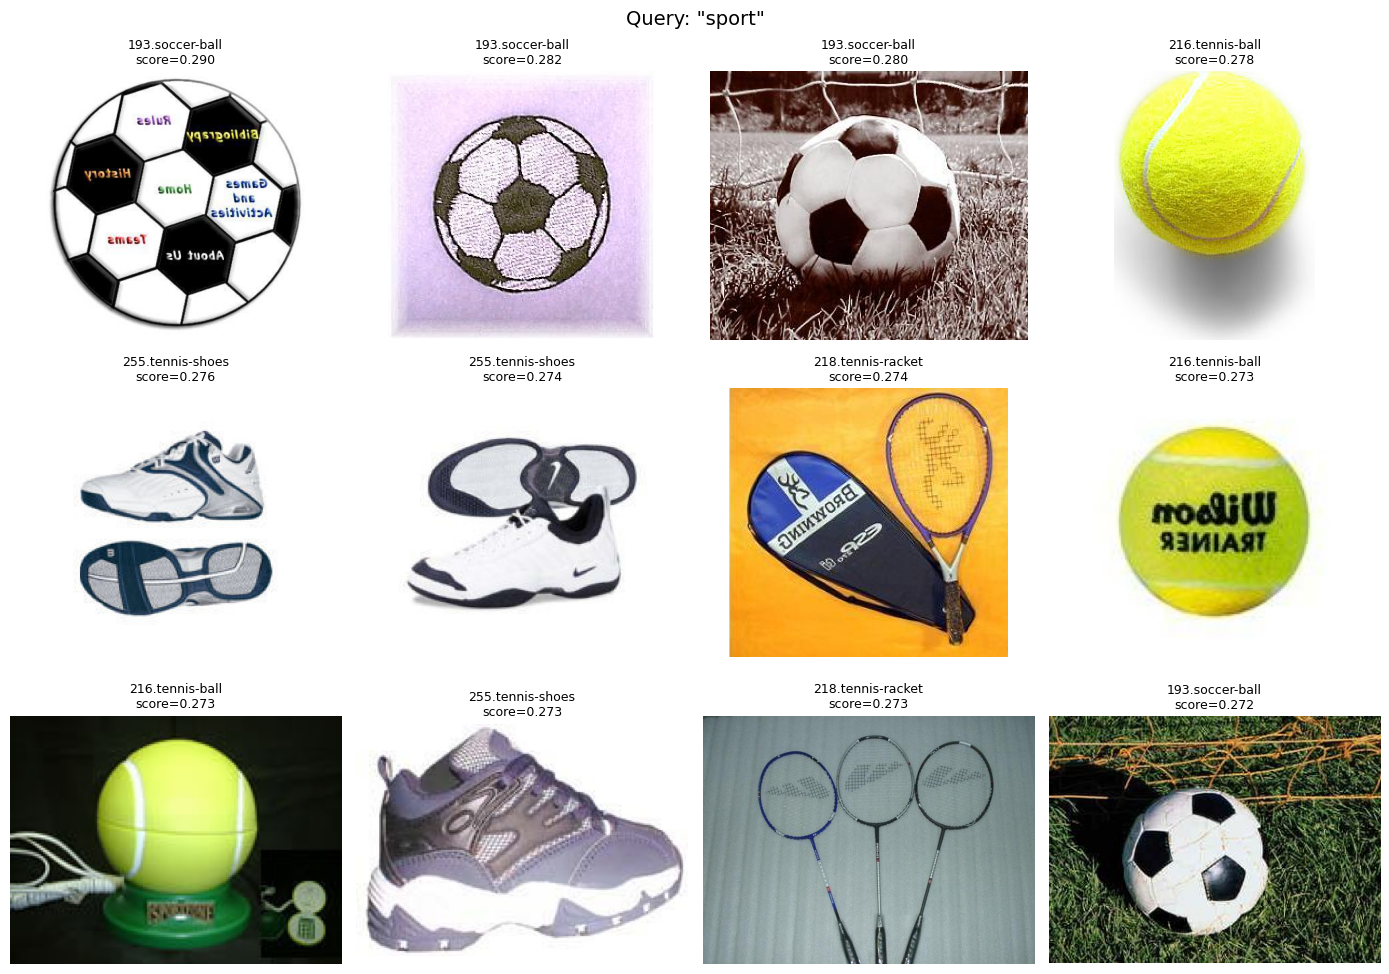

In [24]:
query = "sport"
idxs, scores = search_text_to_image(query, topk=TOPK)
show_results(idxs, scores, suptitle=f'Query: "{query}"')


Al hacer una consulta de fotos de animales obtenemos diferentes especies como gorilas, ballenas, giragas,mapaches, cabras etc

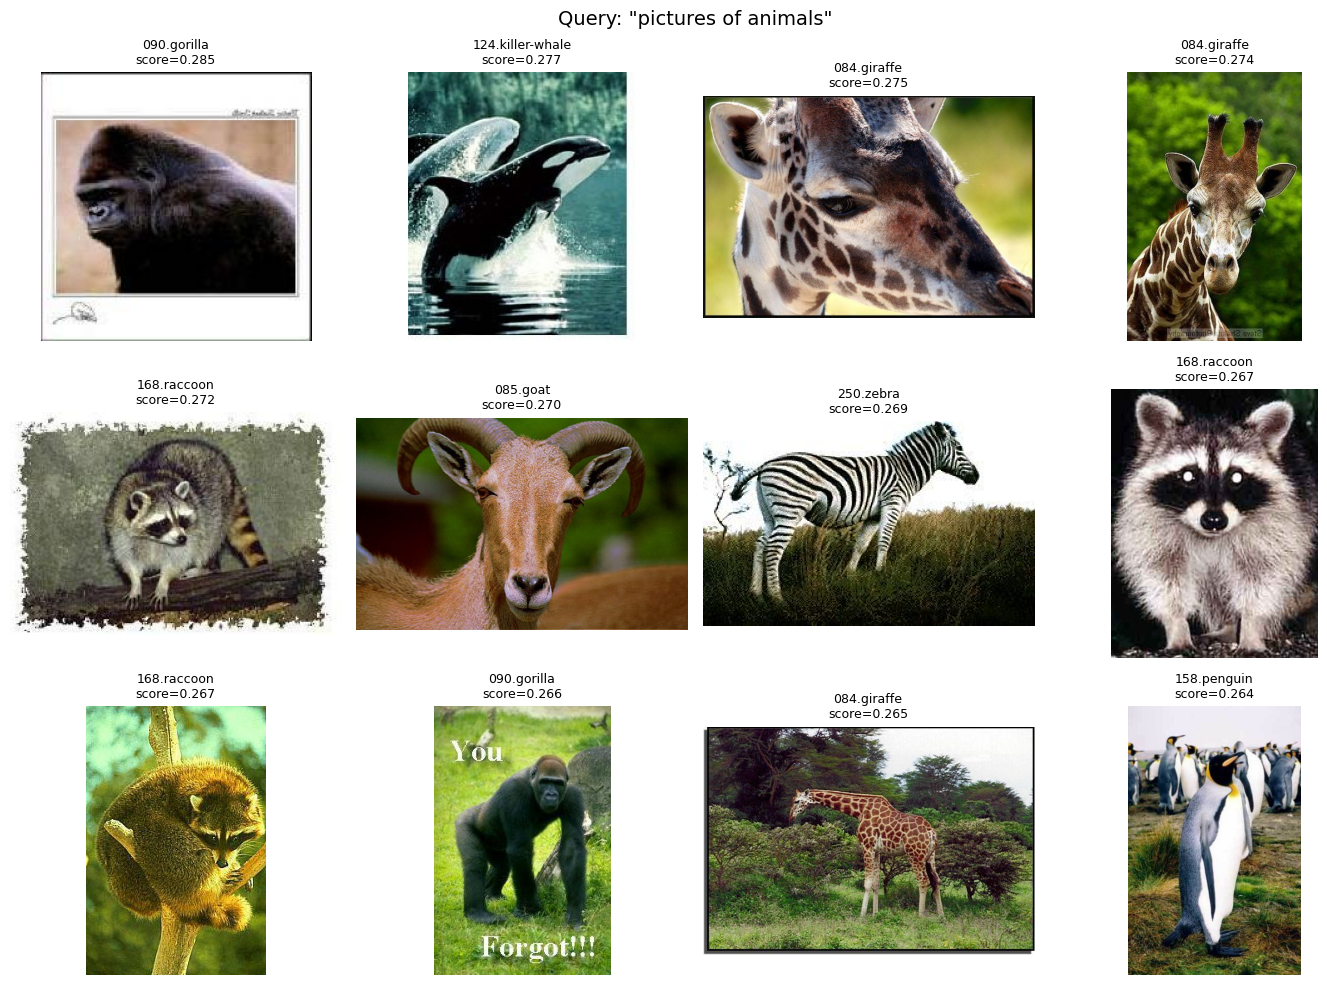

In [25]:
query = "pictures of animals"
idxs, scores = search_text_to_image(query, topk=TOPK)
show_results(idxs, scores, suptitle=f'Query: "{query}"')



## Evaluación



Para una evaluación aproximada sin captions, usamos los nombres de clase como prompts de texto, el prompt es "a photo of a {class_name}". Sobre estos resultados calculamos 
recall@k que es el porcentaje de consultas cuyo top‑K contiene al menos una imagen de la misma clase (al no contar con descripciones humanas por imagen, esta métrica es aproximada pero útil para comparar configuraciones)


In [26]:
def clean_class_name(cname: str):
    """
    Limpia un nombre de clase proveniente del dataset.

    - Remueve prefijos numéricos con punto (p.ej., '123.clase' -> 'clase').
    - Reemplaza guiones y guiones bajos por espacios, para formar prompts más naturales.

    Parámetros
    ----------
    cname : str
        Nombre de la clase original.

    Retorna
    -------
    str
        Nombre de clase limpio y legible para construir prompts de texto.
    """
    parts = cname.split('.', 1)
    if len(parts) == 2:
        cname = parts[1]
    return cname.replace('_', ' ').replace('-', ' ')

In [27]:
@torch.no_grad()
def encode_text_batch(texts):
    """
    Codifica en lote una lista de textos a embeddings normalizados con CLIP.

    Parámetros
    ----------
    texts : List[str]
        Lista de cadenas de texto (prompts) a codificar.

    Retorna
    -------
    np.ndarray
        Matriz (N x D) con los embeddings L2-normalizados de cada texto.
    """
    
    # tokenizamos todos los textos a la vez para eficiencia.
    toks = tokenizer(texts)
    toks = toks.to(DEVICE)
    
    # obtenemos los embeddings con el codificador textual de CLIP.
    tfeats = model.encode_text(toks)
    
    # normalizamos por norma L2 para compatibilidad con similitud coseno.
    tfeats = tfeats / tfeats.norm(dim=-1, keepdim=True)
    return tfeats.detach().cpu().numpy()

Para cada imagen construimos el embedding textual del prompt de su propia clase y recuperamos las K imágenes más similares, contamos como acierto si en ese top-K
aparece al menos una imagen de la misma clase.

In [28]:
def recall_at_k(img_embs, classnames, k=5):
    """
    calcula el Recall@K a nivel de clase usando prompts textuales por clase.

    parámetros
    ----------
    img_embs : np.ndarray
        embeddings de imagen (N x D) previamente normalizados.
    classnames : np.ndarray
        arreglo de nombres de clase (longitud N) alineado con `img_embs`.
    k : int, opcional
        valor de K para el cálculo de Recall@K (por defecto 5).

    Retorna
    -------
    float
        proporción de aciertos (entre 0 y 1) equivalente a Recall@K.
    """
    unique_classes = sorted(set(classnames.tolist()))
    prompts = [f"a photo of a {clean_class_name(c)}" for c in unique_classes]
    tfeats = encode_text_batch(prompts)  # shape: (C, D)

    class_to_row = {c:i for i,c in enumerate(unique_classes)}

    # para cada imagen buscamos vecinos de su prompt
    correct = 0
    for i in tqdm(range(len(classnames)), desc=f"Computando Recall@{k}"):
        cname = classnames[i]
        crow = class_to_row[cname]
        q = tfeats[crow]  # embedding del texto (prompt de su clase)

        D, I = index.search(q[None, :].astype(np.float32), k)
        idxs = I[0]
        
        # revisar si alguno del top-K coincide con su clase
        if np.any(classnames[idxs] == cname):
            correct += 1

    return correct / len(classnames)

for k in [1,5,10]:
    r = recall_at_k(img_embs, y_classnames, k=k)
    print(f"Recall@{k}: {r*100:.2f}%")


Computando Recall@1: 100%|██████████| 5952/5952 [00:03<00:00, 1843.06it/s]


Recall@1: 98.35%


Computando Recall@5: 100%|██████████| 5952/5952 [00:03<00:00, 1942.86it/s]


Recall@5: 99.65%


Computando Recall@10: 100%|██████████| 5952/5952 [00:03<00:00, 1952.52it/s]

Recall@10: 100.00%


Los resultados indican que el sistema de recuperación texto-imagen entrenado con CLIP está funcionando de manera apropiada sobre el subconjunto de Caltech-256 utilizado.

La métrica de Recall@1 = 98.35 % significa que para el 98.35 % de las imágenes, el prompt textual correspondiente a su clase (“a photo of a …”) recuperó en la primera posición una imagen correcta de esa misma clase. En otras palabras, casi todas las imágenes son correctamente identificadas por su descripción textual más simple.

La métrica de Recall@5 = 99.65 %significa que en el 99.65 % de los casos, una imagen correcta aparece dentro de las cinco más similares al prompt textual. Este valor cercano al 100 % muestra que, incluso cuando no es la primera opción, el modelo posiciona casi siempre las imágenes correctas dentro de los primeros resultados.

La métrica de Recall@10 = 100.00 %significa que para todos los casos una imagen de la clase correcta se encuentra entre las diez más similares. Esto implica que el espacio de embeddings aprendido por CLIP separa bien las clases y alinea consistentemente los conceptos visuales con los textuales.


## Uso en otro ambiente

mostramos como uardar los embeddings y metadatos para reusar el índice y acelerar experimentos


In [29]:

SAVE_DIR = Path("./artifacts")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

np.save(SAVE_DIR / "img_embs.npy", img_embs.astype(np.float32))
pd.DataFrame({
    "path": img_paths,
    "class_name": y_classnames,
    "label": y_labels,
}).to_csv(SAVE_DIR / "meta.csv", index=False)

print("guardado en:", SAVE_DIR.resolve())

guardado en: /kaggle/working/artifacts
